<a href="https://colab.research.google.com/github/lustea0201/Interpretability/blob/master/Data_analysis1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the first dataset 

In [1]:
import zipfile
import io
import cv2
import glob 
import numpy as np
import random 
import torch 

torch.manual_seed(0) # Reproducible, for now 

dtype = torch.float
device = torch.device("cpu") 

FIGSIZE = (12,10)

!rm -rf main_dir
!rm -rf data.zip

m = 2 # 1 to import local file, 2 to import from drive

if (m == 1): 
  from google.colab import files
  uploaded = files.upload()
  data = zipfile.ZipFile(io.BytesIO(uploaded['data.zip']), 'r')

if (m == 2): 
  from google.colab import drive
  drive.mount('/content/drive/')

  data = zipfile.ZipFile("/content/drive/My Drive/Interpretability/3000/data1/data.zip", 'r')



root_dir = "main_dir"
data.extractall(root_dir)
data.close()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np

transforms = transforms.Compose( [ToTensor(), 
                                  Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])


train_data = ImageFolder(root = os.path.join(root_dir, 'train'), transform = transforms)

val_data = ImageFolder(root = os.path.join(root_dir, 'val'), transform = transforms)

test_data = ImageFolder(root = os.path.join(root_dir, 'test'), transform = transforms)

idx_to_class = {j:i for i,j in train_data.class_to_idx.items()}


# Dataset description 


*   Label 0: the image doesn't contain any shape 
*   Label 1: the image contains at least one shape 
Here are two examples: 



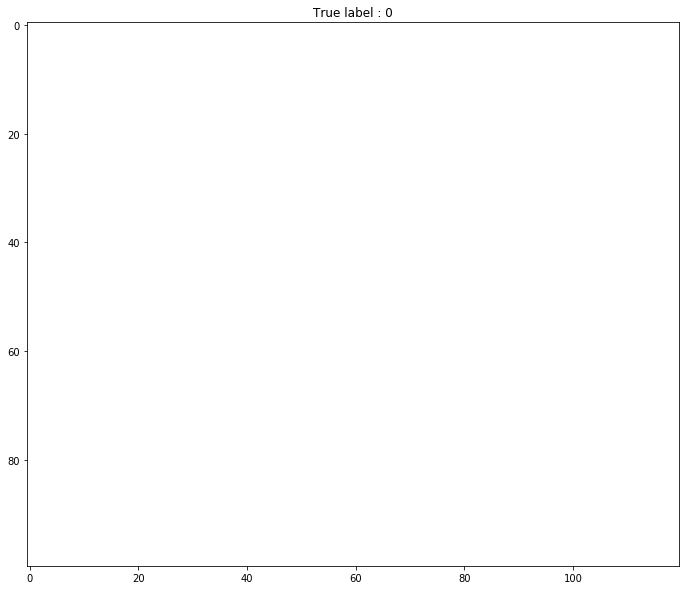

In [3]:


def display_image(image, true_label, predicted_label = None): 
  plt.figure(figsize = FIGSIZE)
  sample_image = image.numpy().transpose(1,2,0)
  mean = np.array([0.5, 0.5, 0.5])
  sd = np.array([0.5, 0.5, 0.5])
  im = sample_image*sd + mean
  plt.imshow(im)
  title_ = "True label : " + idx_to_class[true_label]
  
  if (predicted_label != None):
    title_ += "/ Predicted : " + idx_to_class[predicted_label]


  plt.title(title_)

display_image(train_data[0][0], train_data[0][1])




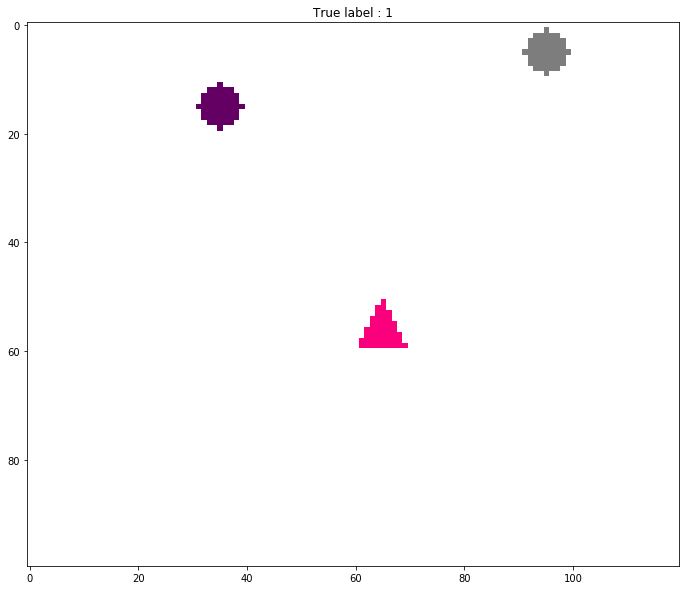

In [4]:
display_image(train_data[-1][0], train_data[-1][1])

In [0]:
batch_Size = 4
dataloader = DataLoader(train_data, batch_size = batch_Size, shuffle = True, num_workers = 0)

valloader = DataLoader(val_data, batch_size = batch_Size, shuffle = True, num_workers = 0)

testloader = DataLoader(test_data, batch_size = batch_Size, shuffle = True, num_workers = 0)

train_loader = iter(dataloader)
x,y = next(train_loader)



# Model description
The neural network used to classify the images receives batches of 3x100x120 images. 
It consists of 
* two convolutional layers followed by max pooling 
* three fully connected layers

https://www.youtube.com/watch?v=fXEdtz8U3Sc

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
  
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(6, 16, 4)
    self.pool2 = nn.MaxPool2d(5)
    self.fc1 = nn.Linear(16 * 9 * 11, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 2)
    self.drop = nn.Dropout(p = 0.5)
  

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = x.view(-1, self.num_flat_features(x)) # 16*9*11
    x = self.drop(F.relu(self.fc1(x)))
    x = self.drop(F.relu(self.fc2(x)))
    x = self.fc3(x)
    return x
  
  def num_flat_features(self, x):
      size = x.size()[1:]  # all dimensions except the batch dimension
      num_features = 1
      for s in size:
          num_features *= s
      return num_features


net = Net()


The network is implemented with cross entropy loss and L2 regularization. 

In [0]:
import torch.optim as optim



criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [8]:
max_epochs = 1000
converged = False
epsilon = 0.0002

def almost_equal(n1, n2, e): 
  return abs(n1-n2) < e



def training_accuracy(network, loader): 
  with torch.no_grad(): 
    correct = 0
    total = 0
    for data in loader: 
      images, labels = data             
      outputs = network(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  return 100 * correct/total


def validation_stats(network, loader, crit): 
  total_loss = 0
  correct = 0
  total = 0
  with torch.no_grad(): 
    for data in loader: 
      images, labels = data             
      outputs = network(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      loss = criterion(outputs, labels)
      total_loss += loss.item()

  return (100 * correct/total, total_loss/len(loader.dataset))

def network_has_converged(loss, e): 
  if (len(loss) < 4):
    return False
  else: 
    return (almost_equal(loss[-4], loss[-3], e) and 
            almost_equal(loss[-4], loss[-2], e) and 
            almost_equal(loss[-4], loss[-1], e) )
          

train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []

for epoch in range(max_epochs):  # loop over the dataset multiple times

  running_loss = 0.0
  if not converged: 
    for i, data in enumerate(dataloader, 0):
      
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)
      loss = criterion(outputs, labels)

      loss.backward()
      optimizer.step()

      # plot loss 
      running_loss += loss.item()

    

    train_loss.append(running_loss/len(dataloader.dataset))
    train_accuracy.append(training_accuracy(net, dataloader))
    A, L = validation_stats(net, valloader, criterion)
    val_loss.append(L)
    val_accuracy.append(A)

    print('Generation %d. training loss: %.4f,' 
          % (epoch + 1, train_loss[-1]), end = "")
    print(" training accuracy: %.2f " % (train_accuracy[-1]), end = "%,")
    print(" validation loss: %.4f," % (val_loss[-1]), end = " ")
    print(" validation accuracy: %.2f " % (val_accuracy[-1]), end="% \n")    

    converged = network_has_converged(train_loss, epsilon)
      
  
if (converged): 
  print ("Network has converged.")
else: 
  print("Network hasn't been able to converge in " + str(max_epochs) + " generations.")

          



Generation 1. training loss: 0.0180, training accuracy: 99.98 %, validation loss: 0.0002,  validation accuracy: 100.00 % 
Generation 2. training loss: 0.0001, training accuracy: 100.00 %, validation loss: 0.0000,  validation accuracy: 100.00 % 
Generation 3. training loss: 0.0000, training accuracy: 100.00 %, validation loss: 0.0000,  validation accuracy: 100.00 % 
Generation 4. training loss: 0.0077, training accuracy: 100.00 %, validation loss: 0.0002,  validation accuracy: 100.00 % 
Generation 5. training loss: 0.0001, training accuracy: 100.00 %, validation loss: 0.0001,  validation accuracy: 100.00 % 
Generation 6. training loss: 0.0000, training accuracy: 100.00 %, validation loss: 0.0000,  validation accuracy: 100.00 % 
Generation 7. training loss: 0.0003, training accuracy: 100.00 %, validation loss: 0.0000,  validation accuracy: 100.00 % 
Generation 8. training loss: 0.0000, training accuracy: 100.00 %, validation loss: 0.0000,  validation accuracy: 100.00 % 
Generation 9. tra

Text(0, 0.5, 'Evaluation of the loss function')

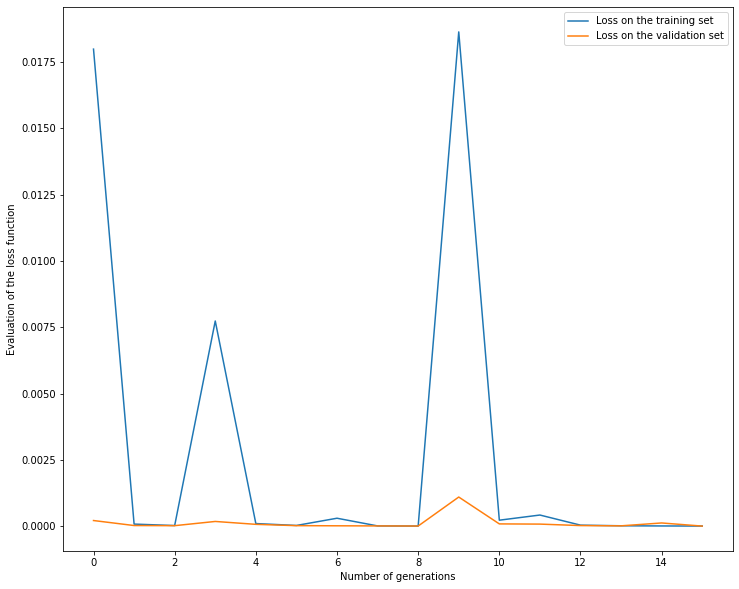

In [9]:
plt.figure(figsize = FIGSIZE)
x_scale = np.linspace(0, len(train_loss)- 1, len(train_loss) )
_ = plt.plot(x_scale, train_loss)
_ = plt.plot(x_scale, val_loss)
plt.legend(["Loss on the training set", "Loss on the validation set"])
plt.xlabel("Number of generations")
plt.ylabel("Evaluation of the loss function")

Text(0, 0.5, 'Accuracy ')

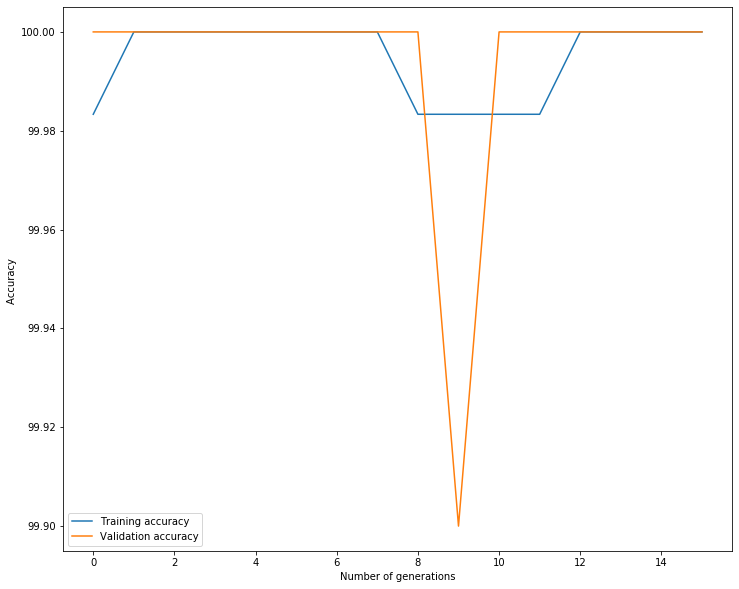

In [10]:
plt.figure(figsize = FIGSIZE)
x_scale = np.linspace(0, len(train_accuracy)- 1, len(train_accuracy) )
_ = plt.plot(x_scale, train_accuracy)
_ = plt.plot(x_scale, val_accuracy)
plt.legend(["Training accuracy", "Validation accuracy"])
plt.xlabel("Number of generations")
plt.ylabel("Accuracy ")

In [11]:
correct = 0
total = 0
wrong_im = []
wrong_label = []
wrongly_predicted_label = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        k = 0
        for truth in (predicted == labels): 
          if not truth: 
            wrong_im.append(images[k])
            wrong_label.append(int(labels[k]))
            wrongly_predicted_label.append(int(predicted[k]))
          k += 1
        
        

print("Accuracy of the network on the " + str(total) + ' test images: %.3f %%' % (
    100 * correct / total))

print("Number of mistakes : " +str(total-correct))
index = 0

Accuracy of the network on the 2000 test images: 100.000 %
Number of mistakes : 0


In [0]:
if index in range(len(wrong_im)):
  display_image(wrong_im[index], wrong_label[index], wrongly_predicted_label[index])
  index += 1

In [0]:
index = 0

In [0]:
torch.save(net.state_dict(), 'drive/My Drive/Interpretability/model1.pth')